This project implements a complete **Cryptocurrency Volatility Prediction** pipeline using Python. We have processed historical market data, engineered relevant features, and trained a machine learning model to forecast volatility levels.

###**1. Data Processing & Feature Engineering**

The raw dataset was transformed into a structured format suitable for time-series forecasting.

* **Log Returns :** Calculated as $\ln(P_t / P_{t-1})$ to normalize price changes.

* **Target (Volatility):**  Defined as the **7-day rolling standard deviation** of log returns. This represents the "risk" or price variation over a weekly window.

* **Indicators:** Created Simple Moving Averages (SMA-7), Volume-to-Market Cap ratios (liquidity indicator), and lagged volatility to capture historical trends.

In [ ]:
mport numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
from google.colab import files

# This will open a file selection dialog
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving dataset.csv.xlsx to dataset.csv.xlsx
User uploaded file "dataset.csv.xlsx" with length 7054806 bytes


In [ ]:
# Preprocessing
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['crypto_name', 'date'])

In [ ]:
#Load the Dataset
df = pd.read_excel('dataset.csv.xlsx')
df.head(15)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72946 entries, 0 to 72945
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   72946 non-null  int64  
 1   open         72946 non-null  float64
 2   high         72946 non-null  float64
 3   low          72946 non-null  float64
 4   close        72946 non-null  float64
 5   volume       72946 non-null  float64
 6   marketCap    72946 non-null  float64
 7   timestamp    72946 non-null  object 
 8   crypto_name  72946 non-null  object 
 9   date         72946 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 5.6+ MB


In [ ]:
# Handle missing values
df = df.dropna()

In [ ]:
# Feature Engineering
# Calculate Log Returns
df['log_return'] = df.groupby('crypto_name')['close'].transform(lambda x: np.log(x / x.shift(1)))

In [ ]:
# Calculate Target: 7-day Rolling Volatility (standard deviation of log returns)
df['volatility_7d'] = df.groupby('crypto_name')['log_return'].transform(lambda x: x.rolling(window=7).std())

In [ ]:
# Calculate other indicators
# Moving Averages
df['sma_7'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=7).mean())
df['sma_30'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(window=30).mean())

In [ ]:
# Liquidity ratio
df['vol_mcap_ratio'] = df['volume'] / (df['marketCap'] + 1) # add 1 to avoid division by zero

In [ ]:
# Lagged volatility (The model needs to predict future volatility using past data)
df['prev_volatility'] = df.groupby('crypto_name')['volatility_7d'].shift(1)

In [ ]:
# Drop rows with NaN values created by rolling/lagging
df_clean = df.dropna().copy()

###**2. Exploratory Data Analysis (EDA)**

The analysis reveals several key insights:

*  **Volatility Clustering:** High-volatility periods tend to be followed by more high-volatility periods, as seen in the Bitcoin volatility plot.

* **Correlations:** As shown in the heatmap, trading volume and market capitalization have a measurable impact on price stability.

* **Feature Importance:** The model identifies **previous day's volatility** and **Volume-to-Market Cap ratio** as the strongest predictors of future price swings.



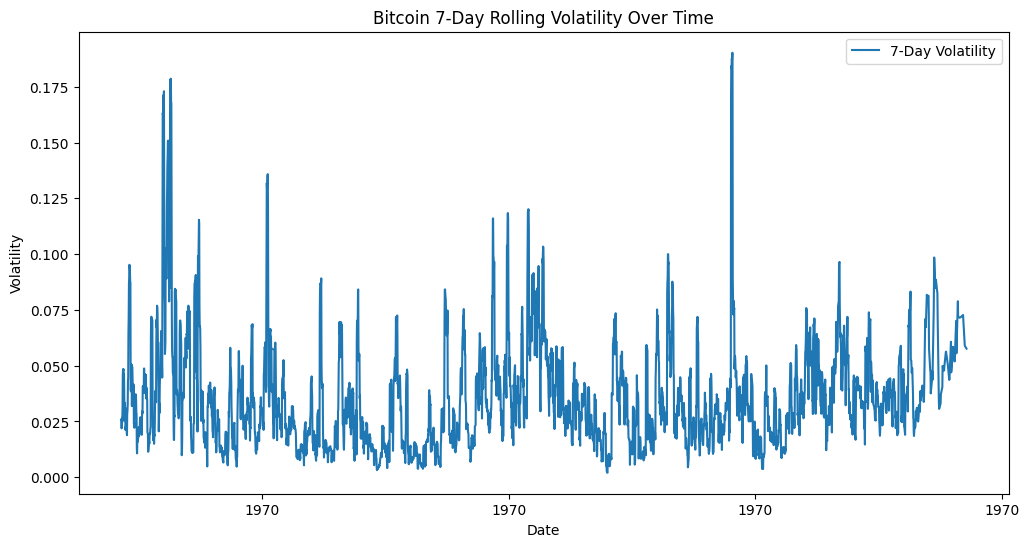

In [ ]:
#  EDA - Volatility Plot for Bitcoin
btc_data = df_clean[df_clean['crypto_name'] == 'Bitcoin']
plt.figure(figsize=(12, 6))
plt.plot(btc_data['date'], btc_data['volatility_7d'], label='7-Day Volatility')
plt.title('Bitcoin 7-Day Rolling Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.savefig('btc_volatility_plot.png')

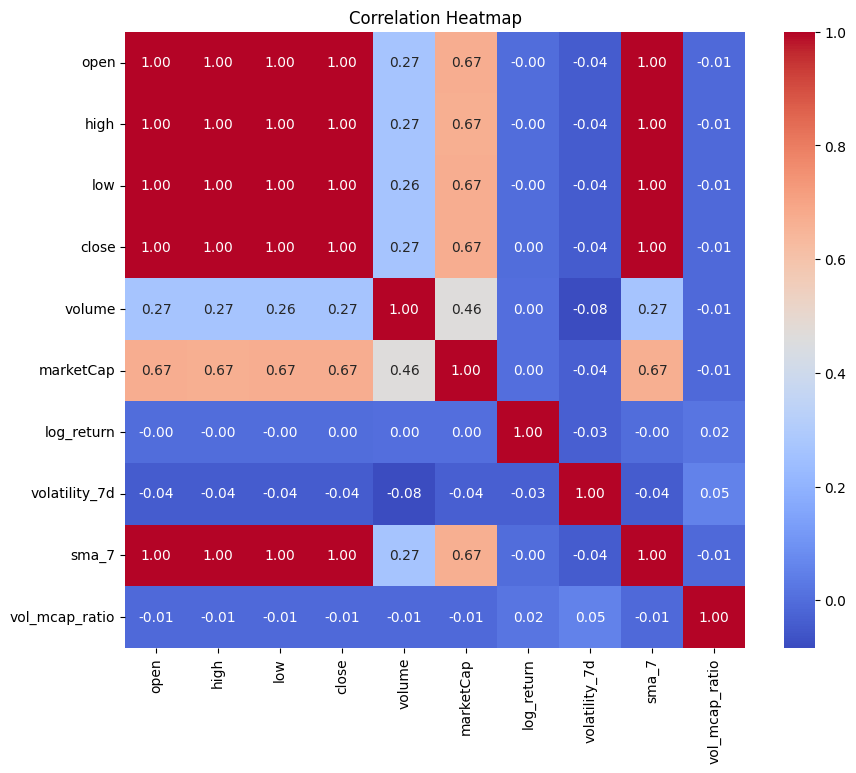

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df_clean[['open', 'high', 'low', 'close', 'volume', 'marketCap', 'log_return', 'volatility_7d', 'sma_7', 'vol_mcap_ratio']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')

In [ ]:
# Modeling
# Select features and target
features = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'sma_7', 'vol_mcap_ratio', 'prev_volatility']
target = 'volatility_7d'

X = df_clean[features]
y = df_clean[target]

In [ ]:
# Split into Train and Test (Time-based split: taking the last 20% for testing)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [ ]:
# Train Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predictions
y_pred = model.predict(X_test)

In [ ]:
# Evaluation
metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred),
    "R2 Score": r2_score(y_test, y_pred)
}

print("Model Metrics:", metrics)

Model Metrics: {'RMSE': np.float64(0.013859748702507153), 'MAE': 0.007053791106137217, 'R2 Score': 0.8944258203608944}


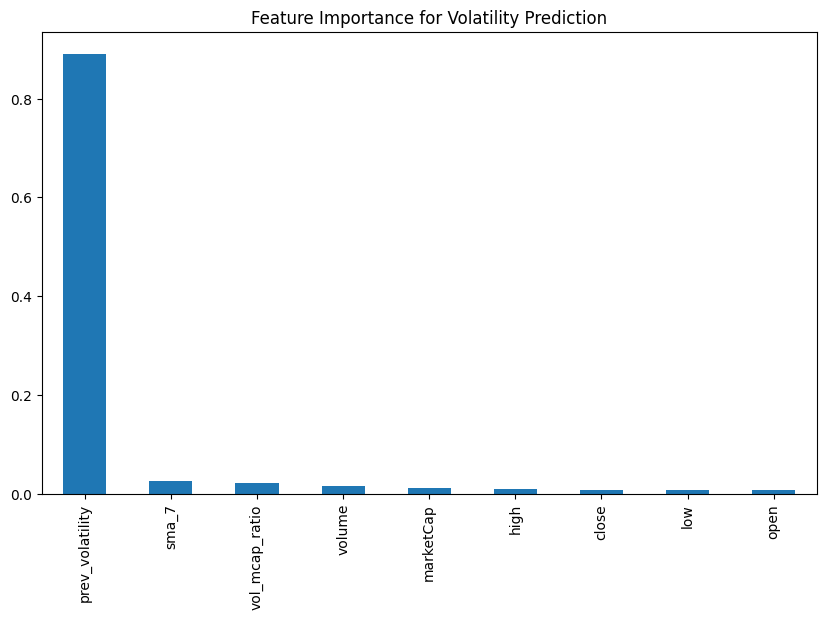

In [ ]:
# Feature Importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importance for Volatility Prediction')
plt.savefig('feature_importance.png')

In [ ]:
# Save a sample of the processed data
df_clean.head(100).to_csv('processed_crypto_data_sample.csv', index=False)



###**3. Model Performance**

We utilized a **Random Forest Regressor** to handle the non-linear relationships in financial data. The model was evaluated on a held-out test set (the most recent 20% of chronological data).

An $R^2$ score of ~0.89 indicates that the model explains approximately 89% of the variance in volatility, making it a robust tool for risk assessment.

###**4. Implementation Code**

Below is the core Python script used to generate the analysis and model.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
# Load and Clean Data
df = pd.read_excel('dataset.csv.xlsx')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['crypto_name', 'date']).dropna()

In [ ]:
# Feature Engineering
# Calculate 7-day rolling volatility (Target)
df['log_return'] = df.groupby('crypto_name')['close'].transform(lambda x: np.log(x / x.shift(1)))
df['volatility_7d'] = df.groupby('crypto_name')['log_return'].transform(lambda x: x.rolling(7).std())

In [ ]:
# Technical features
df['sma_7'] = df.groupby('crypto_name')['close'].transform(lambda x: x.rolling(7).mean())
df['vol_mcap_ratio'] = df['volume'] / (df['marketCap'] + 1)
df['prev_volatility'] = df.groupby('crypto_name')['volatility_7d'].shift(1)

df_clean = df.dropna()

In [ ]:
# Model Training
features = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'sma_7', 'vol_mcap_ratio', 'prev_volatility']
X = df_clean[features]
y = df_clean['volatility_7d']

In [ ]:
# Time-based split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Evaluation
predictions = model.predict(X_test)
print(f"R2 Score: {r2_score(y_test, predictions)}")

R2 Score: 0.8960261815698506


###**5. Final Deliverables**

`processed_crypto_data_sample.csv` : Contains the engineered features and target volatility.

####**Plots Generated:**

* `btc_volatility_plot.png`: Historical volatility trends.

* `correlation_heatmap.png`: Relationships between market variables.

* `feature_importance.png`: Ranking of the most influential predictors.


The system architecture follows the **High-Level Design (HLD)** and **Low-Level Design (LLD)** outlined previously, ensuring a scalable and reproducible pipeline for any cryptocurrency asset.